```
part a) an objective is to minimize error
```

```
part b) the support samples are those closest to the hyperplane that "support" the position of the hyperplane.
```

```
part c) download dataset
```

In [1]:
# download dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
ds = fetch_openml(name='mnist_784', as_frame=False)

x, x_test, y, y_test = train_test_split(ds.data, ds.target, test_size=0.2, random_state=42)

# change type for torch
x, x_test = x.astype(np.float32), x_test.astype(np.float32)


```
check download
```

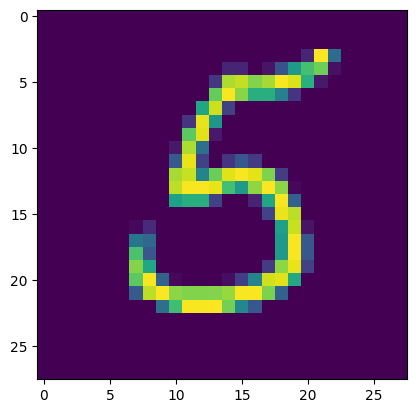

In [2]:
import matplotlib.pyplot as plt

a = x[0].reshape(28,28)
plt.imshow(a)

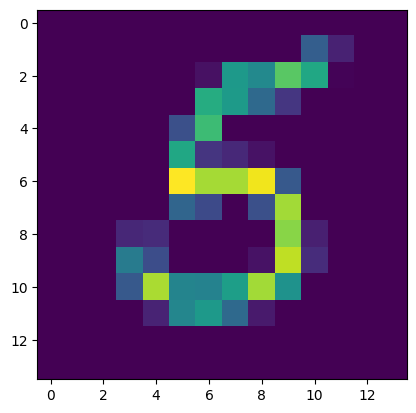

In [3]:
# down sample due to decrease the RAM required to fit an SVM
import cv2

#must chagne to float type
b = a.astype(np.float32)

b = cv2.resize(b, (14, 14))
plt.imshow(b)

```
downsample the images to 14x14 to reduce the number of features and train the SVM quicker
```

In [4]:
import numpy as np
from collections import defaultdict


# init dict to store samples for each digit
digit_samples = defaultdict(list)

for idx, (image, label) in enumerate(zip(x, y)):
    digit_samples[label].append(idx)

# store new dataset
x_balanced = []
y_balanced = []

for digit in range(10):
    digit_str = str(digit)

    # select samples
    if len(digit_samples[digit_str]) > 1000:
        selected_indices = np.random.choice(digit_samples[digit_str], 1000, replace=False)
    else:
        selected_indices = digit_samples[digit_str]
    
    x_balanced.extend(x[selected_indices])
    y_balanced.extend([digit_str] * len(selected_indices))

x_balanced = np.array(x_balanced)
y_balanced = np.array(y_balanced)

# shuffle
shuffle_idx = np.random.permutation(len(x_balanced))
x_balanced = x_balanced[shuffle_idx]
y_balanced = y_balanced[shuffle_idx]

print(f"Shape of balanced dataset: {x_balanced.shape}")
print(f"Number of samples for each digit:")
for digit in range(10):
    print(f"Digit {digit}: {np.sum(y_balanced == str(digit))}")

# downsample the images to 14x14
x_balanced_downsampled = np.array([cv2.resize(img.reshape(28, 28), (14, 14)).flatten() for img in x_balanced])

print(f"Shape of downsampled balanced dataset: {x_balanced_downsampled.shape}")


Shape of balanced dataset: (10000, 784)
Number of samples for each digit:
Digit 0: 1000
Digit 1: 1000
Digit 2: 1000
Digit 3: 1000
Digit 4: 1000
Digit 5: 1000
Digit 6: 1000
Digit 7: 1000
Digit 8: 1000
Digit 9: 1000
Shape of downsampled balanced dataset: (10000, 196)


`check that sampling was correct`

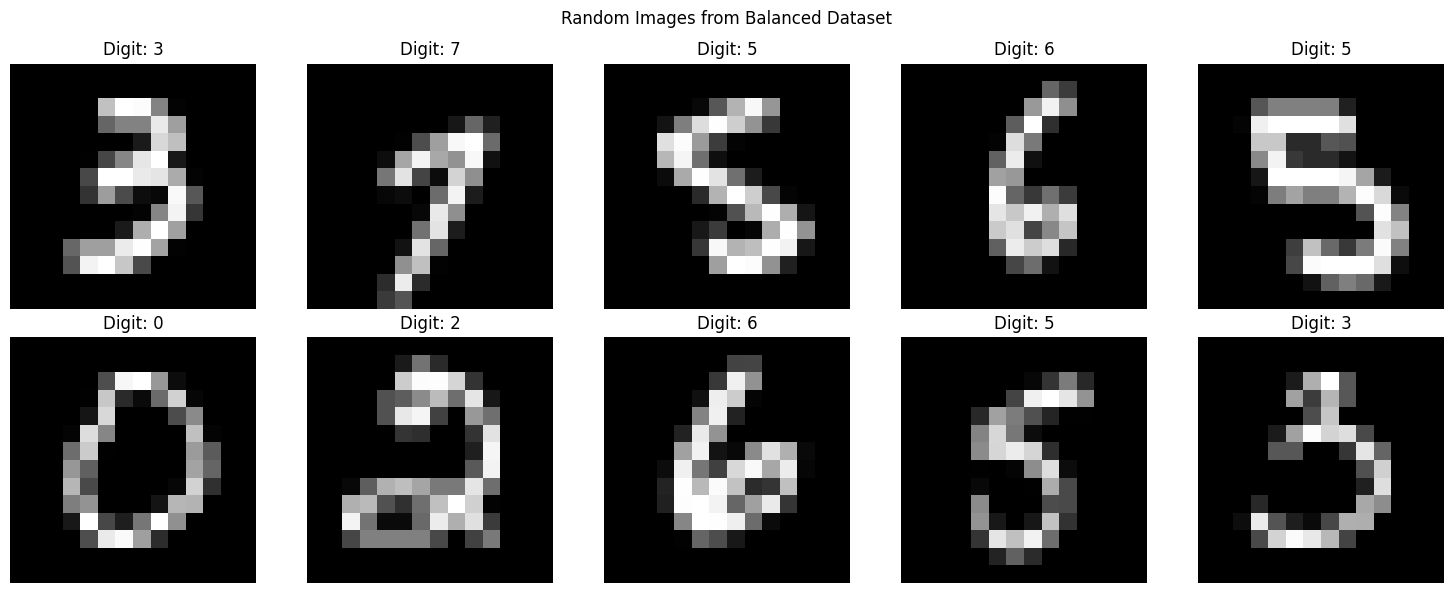

Shape of a single downsampled image: (196,)


In [5]:
n_images = 10

# Randomly select indices
random_indices = np.random.choice(len(x_balanced_downsampled), n_images, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Random Images from Balanced Dataset")

for i, ax in enumerate(axes.flat):
    # Get the image and its label
    img = x_balanced_downsampled[random_indices[i]].reshape(14, 14)
    label = y_balanced[random_indices[i]]
    
    # Display the image
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Digit: {label}")

plt.tight_layout()
plt.show()

print("Shape of a single downsampled image:", x_balanced_downsampled[0].shape)


In [6]:
# 80/20 split
X_train, X_val, y_train, y_val = train_test_split(x_balanced_downsampled, y_balanced, test_size=0.2, random_state=42)

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of validation set: {X_val.shape}")
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in validation set: {len(X_val)}")

# distribution of digits
print("\nDistribution of digits in training set:")
for digit in range(10):
    print(f"Digit {digit}: {np.sum(y_train == str(digit))}")

print("\nDistribution of digits in validation set:")
for digit in range(10):
    print(f"Digit {digit}: {np.sum(y_val == str(digit))}")


Shape of training set: (8000, 196)
Shape of validation set: (2000, 196)
Number of samples in training set: 8000
Number of samples in validation set: 2000

Distribution of digits in training set:
Digit 0: 783
Digit 1: 802
Digit 2: 785
Digit 3: 785
Digit 4: 798
Digit 5: 795
Digit 6: 824
Digit 7: 799
Digit 8: 822
Digit 9: 807

Distribution of digits in validation set:
Digit 0: 217
Digit 1: 198
Digit 2: 215
Digit 3: 215
Digit 4: 202
Digit 5: 205
Digit 6: 176
Digit 7: 201
Digit 8: 178
Digit 9: 193


```
part d) fit an SVM to dataset
```

In [7]:
from sklearn import svm

classifier = svm.SVC(C=1.0, kernel='rbf', gamma='auto')

classifier.fit(X_train, y_train)

y_val_pred = classifier.predict(X_val)

accuracy = np.mean(y_val_pred == y_val)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 0.0880


`note down the # of support samples to total training samples`

In [8]:
# get # of SVMs
n_support_vectors = classifier.n_support_.sum()

# ratio of support to total samples
ratio = n_support_vectors / len(X_train)

print(f"Ratio of support vectors to total training samples: {ratio:.4f}")

Ratio of support vectors to total training samples: 1.0000


`run classifier on test set`

In [9]:
# resizing
x_test_resized = np.array([cv2.resize(img.reshape(28, 28), (14, 14)).flatten() for img in x_test])

# use resized data
x_test = x_test_resized

# Note: y_test doesn't need resizing as it contains labels
print(f"New x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


New x_test shape: (14000, 196)
y_test shape: (14000,)


In [10]:
y_test_pred = classifier.predict(x_test)

# get accuracy
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# support vectors and ratio
n_support_vectors_test = classifier.n_support_.sum()
ratio_test = n_support_vectors_test / len(x_test)
print(f"Number of support vectors: {n_support_vectors_test}")
print(f"Ratio of support vectors to total test samples: {ratio_test:.4f}")


Test accuracy: 0.0997
Number of support vectors: 8000
Ratio of support vectors to total test samples: 0.5714


`report the 10-class confusion matrix`

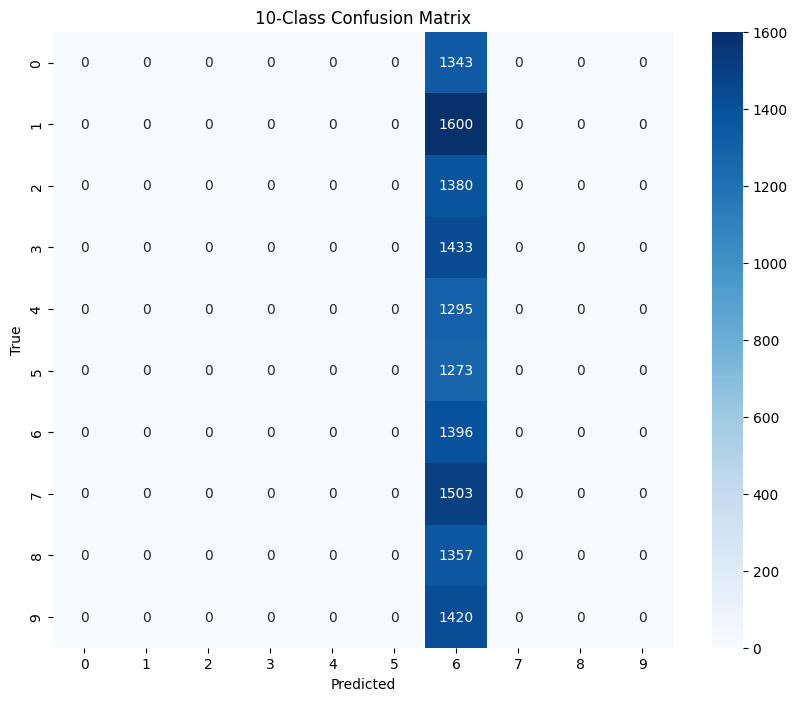

Confusion Matrix:
[[   0    0    0    0    0    0 1343    0    0    0]
 [   0    0    0    0    0    0 1600    0    0    0]
 [   0    0    0    0    0    0 1380    0    0    0]
 [   0    0    0    0    0    0 1433    0    0    0]
 [   0    0    0    0    0    0 1295    0    0    0]
 [   0    0    0    0    0    0 1273    0    0    0]
 [   0    0    0    0    0    0 1396    0    0    0]
 [   0    0    0    0    0    0 1503    0    0    0]
 [   0    0    0    0    0    0 1357    0    0    0]
 [   0    0    0    0    0    0 1420    0    0    0]]


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('10-Class Confusion Matrix')

plt.show()

print("Confusion Matrix:")
print(cm)


```
part g) train for multiple classes
```

In [12]:
from sklearn.model_selection import GridSearchCV

# parameters for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

svm_classifier = svm.SVC()

# create grid search
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("All parameters: ", grid_search.cv_results_)
print("Best parameters: ", grid_search.best_params_)


All parameters:  {'mean_fit_time': array([37.24719071, 14.80796213,  5.71517282,  5.06742835,  3.69438577]), 'std_fit_time': array([0.07700327, 0.18937955, 0.82272458, 0.09053513, 1.48320676]), 'mean_score_time': array([4.21859059, 3.22935209, 1.92735777, 1.54295058, 1.00660377]), 'std_score_time': array([0.02009322, 0.24138381, 0.11140779, 0.06776817, 0.19420505]), 'param_C': masked_array(data=[0.01, 0.1, 1.0, 10.0, 100.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}], 'split0_test_score': array([0.756875, 0.921875, 0.9525  , 0.95875 , 0.958125]), 'split1_test_score': array([0.739375, 0.91375 , 0.95125 , 0.96125 , 0.96125 ]), 'split2_test_score': array([0.755625, 0.91875 , 0.95375 , 0.96375 , 0.964375]), 'split3_test_score': array([0.735625, 0.916875, 0.950625, 0.955625, 0.956875]), 'split4_test_score': array([0.745   , 0.92375 , 0.958125, 0.958125, 0.958125]), 'mean_test_score': a

```
part h) train using
```

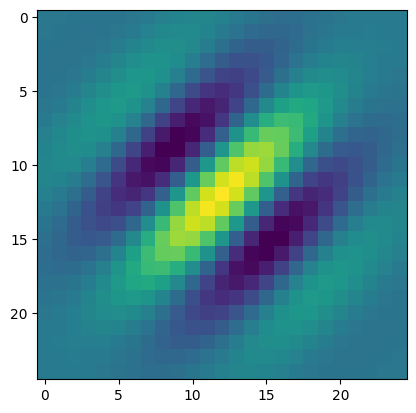

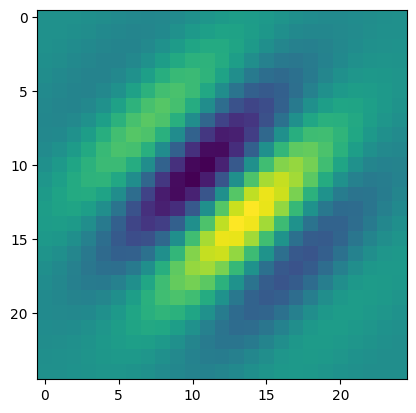

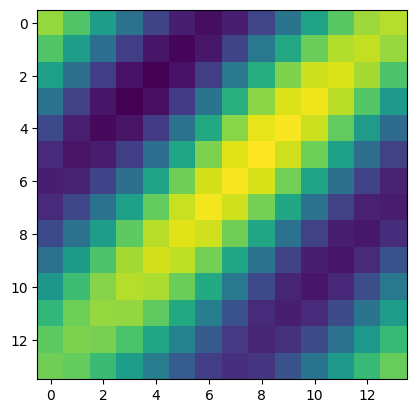

In [34]:
from skimage.filters import gabor, gabor_kernel

freq, theta, bandwidth = 0.1, np.pi/4, 1
gk = gabor_kernel(frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(1); plt.clf(); plt.imshow(gk.real)
plt.figure(2); plt.clf(); plt.imshow(gk.imag)

image = X_train[0].reshape((14 ,14))
coeff_real , _ = gabor (image , frequency =freq , theta =theta , bandwidth =bandwidth )
plt.figure(3); plt.clf(); plt.imshow(coeff_real)

```
part j) hyperparameter tuning
```

In [14]:
# Define parameter ranges
theta = list(np.arange(0, np.pi, np.pi/4))
frequency = list(np.arange(0.05, 0.5, 0.15))
bandwidth = list(np.arange(0.3, 1, 0.3))

```
create filter bank
```

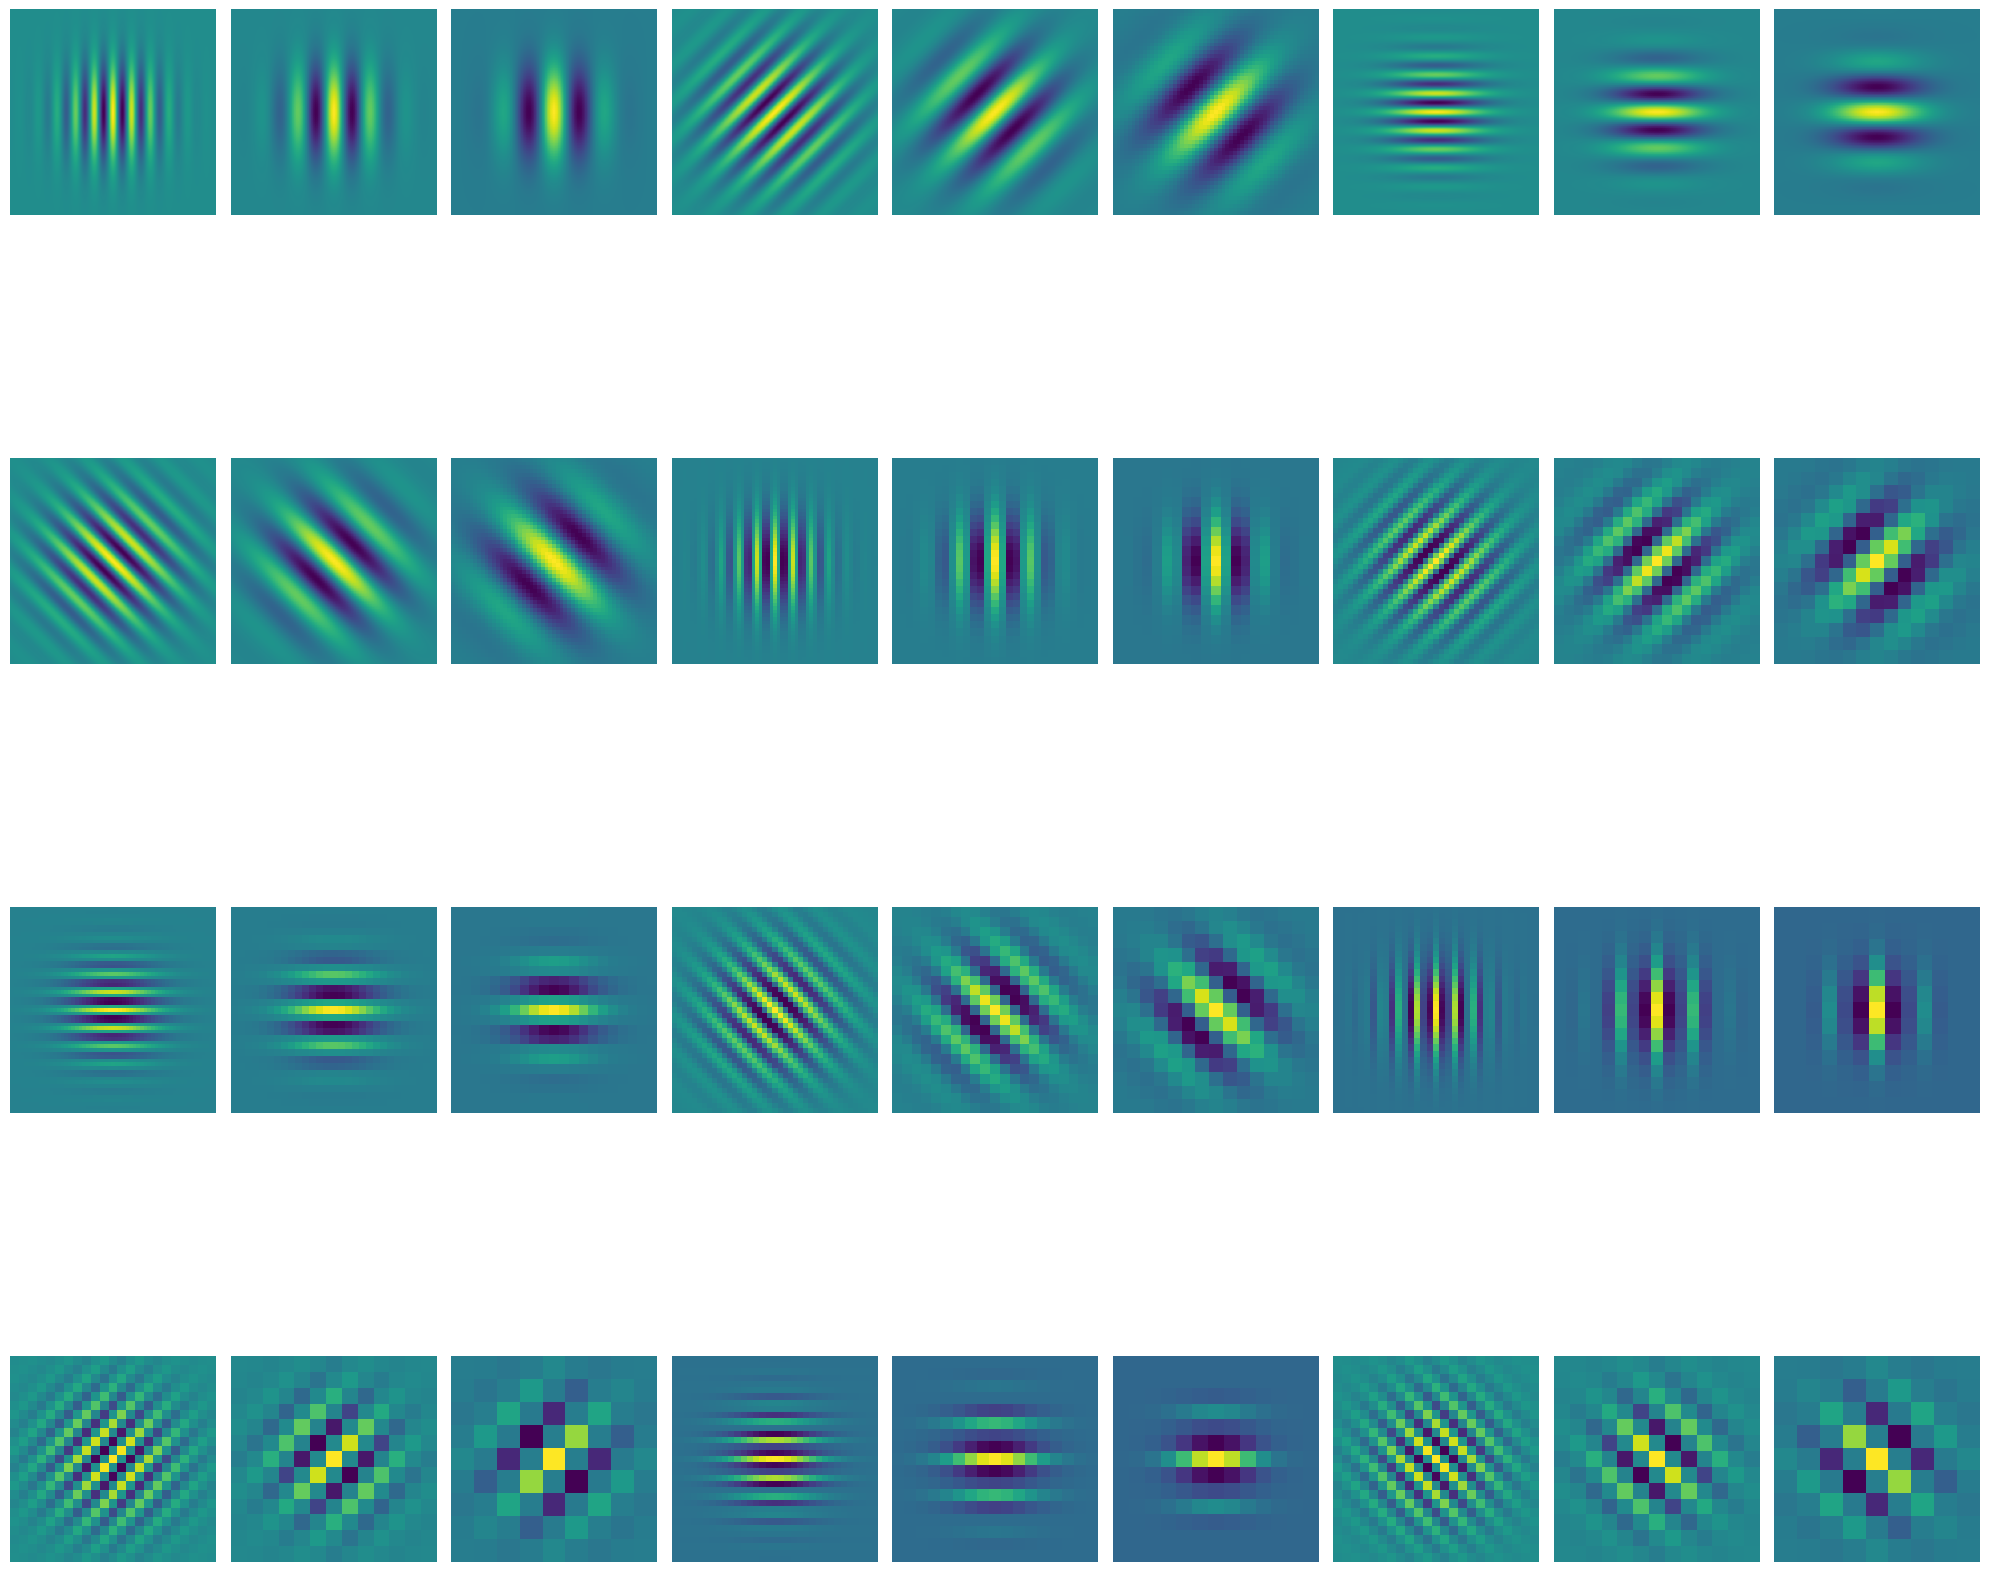

In [16]:
filter_params_bank = [
    {'frequency': f, 'theta': t, 'bandwidth': b}
    for f in frequency
    for t in theta
    for b in bandwidth
]

# filter bank of all filters
filter_bank = [
    gabor_kernel(**params) for params in filter_params_bank
]

# plot filter bank
fig, axes = plt.subplots(nrows=len(theta), ncols=len(frequency)*len(bandwidth), figsize=(20, 20))
for idx, (ax, kernel) in enumerate(zip(axes.flatten(), filter_bank)):
    ax.imshow(np.real(kernel))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [32]:
from sklearn.decomposition import PCA
import gc

def apply_filter_bank(image, filter_params_bank):
    img = image.reshape((14, 14))
    filtered = np.array([gabor(img, **filter_params)[0] for filter_params in filter_params_bank])

    return filtered.ravel()


In [18]:
from tqdm import tqdm
gc.collect()

83283

In [19]:
samples_per_class = 100

# dict to store indices for each class
class_indices = {label: [] for label in np.unique(y_train)}

# get 100 samples per class
for idx, label in enumerate(y_train):
    if len(class_indices[label]) < samples_per_class:
        class_indices[label].append(idx)

# combine all selected indices
selected_indices = np.concatenate(list(class_indices.values()))

# shuffle
np.random.shuffle(selected_indices)

# select the subset of training data
X_train_subset = X_train[selected_indices]
y_train_subset = y_train[selected_indices]

print(f"Original training set shape: {X_train.shape}")
print(f"Subset training set shape: {X_train_subset.shape}")


Original training set shape: (8000, 196)
Subset training set shape: (1000, 196)


In [20]:
print("Processing training data...")
X_train_filtered = np.array([apply_filter_bank(img, filter_params_bank) for img in tqdm(X_train_subset)])
print("X_train_filtered shape:", X_train_filtered.shape)


Processing training data...


100%|██████████| 1000/1000 [24:04<00:00,  1.44s/it]

X_train_filtered shape: (1000, 7056)


In [21]:
X_train_filtered.shape

(1000, 7056)

In [22]:
print("Applying PCA to training data...")
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_filtered)
print("X_train_pca shape:", X_train_pca.shape)

Applying PCA to training data...
X_train_pca shape: (1000, 100)


0

In [29]:
from sklearn.svm import SVC


print("Training SVM...")
svm = SVC(kernel='rbf', C=10)
svm.fit(X_train_pca, y_train_subset)

Training SVM...


SVC(C=10)

In [36]:
print("Processing validation data...")
X_val_filtered = np.array([apply_filter_bank(img, filter_params_bank) for img in tqdm(X_val)])
print("X_val_filtered shape:", X_val_filtered.shape)

Processing validation data...


100%|██████████| 2000/2000 [51:25<00:00,  1.54s/it] 


X_val_filtered shape: (2000, 7056)


In [37]:
print("Applying PCA to validation data...")
X_val_pca = pca.transform(X_val_filtered)
print("X_val_pca shape:", X_val_pca.shape)

Applying PCA to validation data...
X_val_pca shape: (2000, 100)


In [38]:
print("Evaluating model...")
val_accuracy = svm.score(X_val_pca, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

Evaluating model...
Validation accuracy: 0.9190
